<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-setup" data-toc-modified-id="Imports-and-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and setup</a></span></li><li><span><a href="#Goal" data-toc-modified-id="Goal-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Goal</a></span><ul class="toc-item"><li><span><a href="#What-do-we-want-to-infer?" data-toc-modified-id="What-do-we-want-to-infer?-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>What do we want to infer?</a></span></li><li><span><a href="#What-do-we-want?" data-toc-modified-id="What-do-we-want?-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>What do we want?</a></span></li></ul></li><li><span><a href="#Read-Data" data-toc-modified-id="Read-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#The-model" data-toc-modified-id="The-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>The model</a></span></li></ul></div>

# Imports and setup

A [link](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/rugby_analytics.html) to the tutorial I am following

This is just to help me familiarise myself with PyMC

In [1]:
!date

Tue 30 Nov 2021 04:29:58 PM NZDT


In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tf
import xarray as xr

In [3]:
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

In [4]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

# Goal

## What do we want to infer?
* We want to infer the latent paremeters (every team’s strength) that are generating the data we observe (the scorelines).

* Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.

* Often we don’t know what the Bayesian Model is explicitly, so we have to ‘estimate’ the Bayesian Model’

* If we can’t solve something, approximate it.

* Markov-Chain Monte Carlo (MCMC) instead draws samples from the posterior.

* Fortunately, this algorithm can be applied to almost any model.

## What do we want?
* We want to quantify our uncertainty

* We want to also use this to generate a model

* We want the answers as distributions not point estimates

# Read Data

In [5]:
df_all = pd.read_csv("rugby.csv")
df_all.head()

,home_team,away_team,home_score,away_score,year
0,ireland,italy,29,11,2010
1,england,wales,30,17,2010
2,scotland,france,9,18,2010
3,wales,scotland,31,24,2010
4,france,ireland,33,10,2010


In [6]:
df_all.describe()

,home_score,away_score,year
count,135.000000,135.000000,135.000000
mean,23.111111,17.970370,2014.000000
std,12.264295,10.347644,2.591605
min,0.000000,0.000000,2010.000000
25%,15.500000,10.500000,2012.000000
50%,21.000000,16.000000,2014.000000
75%,29.000000,22.500000,2016.000000
max,67.000000,63.000000,2018.000000


In [7]:
df_all.shape

(135, 5)

# EDA

In [8]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])
df_all.head()

,home_team,away_team,home_score,away_score,year,difference
0,ireland,italy,29,11,2010,18
1,england,wales,30,17,2010,13
2,scotland,france,9,18,2010,9
3,wales,scotland,31,24,2010,7
4,france,ireland,33,10,2010,23


Text(0, 0.5, 'Average (abs) point difference')

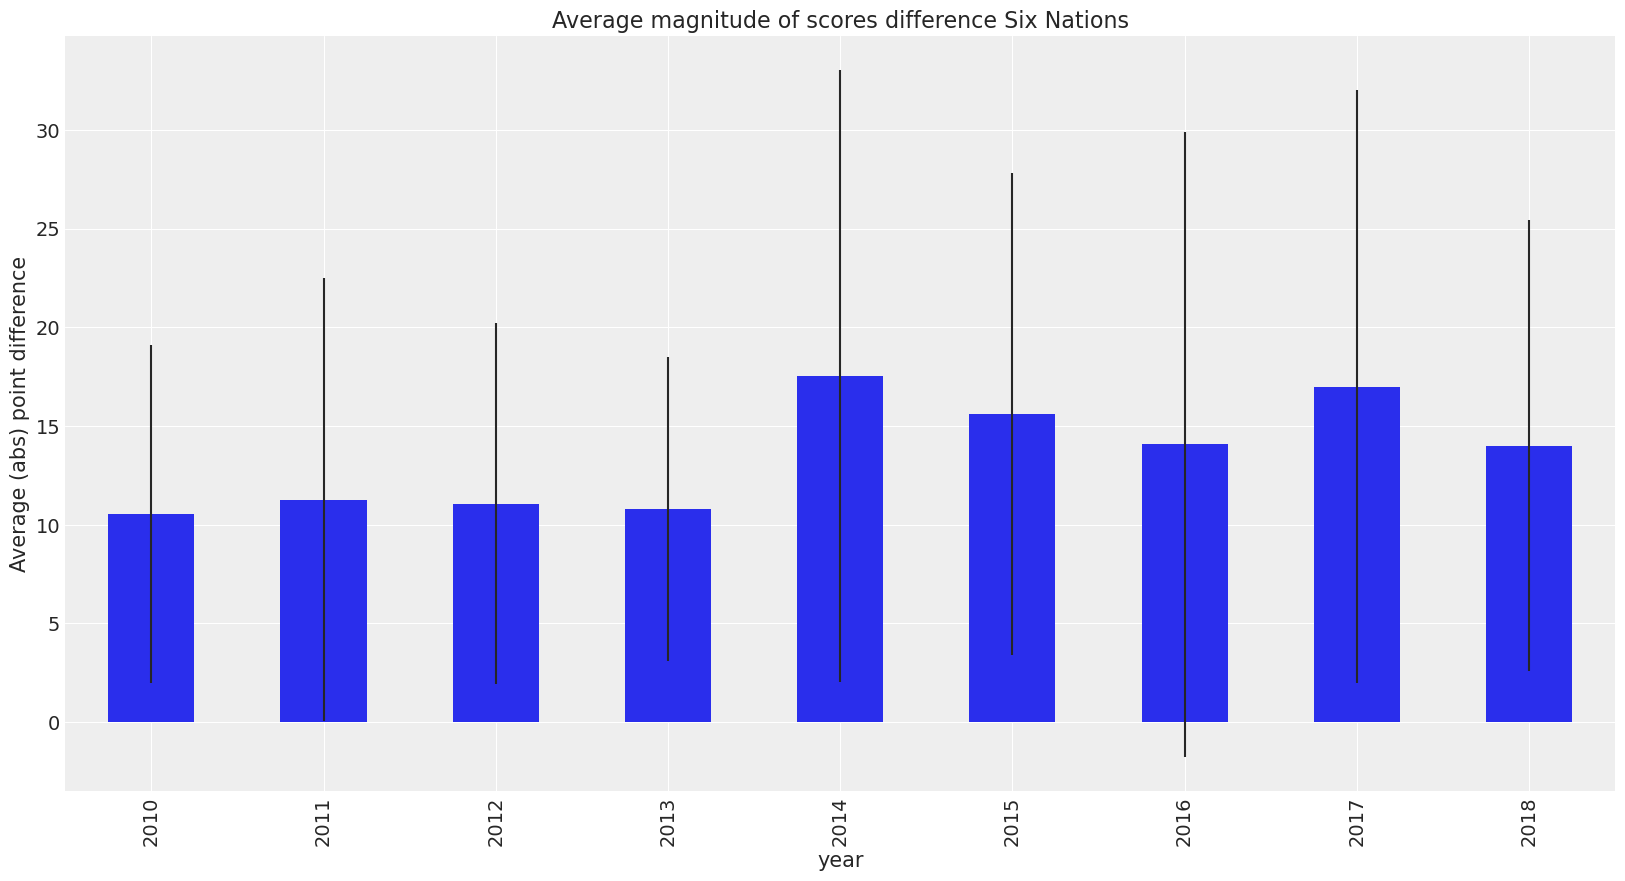

In [9]:
df_grouped = df_all.groupby("year")["difference"].mean()

plt.figure(figsize=(20, 10))

df_grouped.plot(
    kind="bar",
    title="Average magnitude of scores difference Six Nations",
    yerr=df_all.groupby("year")["difference"].std(),
).set_ylabel("Average (abs) point difference")

We can see that the standard error is large. So we can’t say anything about the differences. Let’s look country by country.

In [10]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]

In [11]:
df_all.pivot_table("difference_non_abs", "home_team", "year")

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
home_team,,,,,,,,,
england,4.5,20.000000,7.000000,12.333333,7.000000,20.666667,7.500000,21.333333,-1.500000
france,17.0,16.000000,5.333333,-1.500000,6.666667,0.000000,-2.333333,4.000000,7.000000
ireland,10.0,6.500000,16.000000,-3.000000,28.000000,8.500000,17.666667,7.000000,22.333333
italy,-0.5,-3.000000,1.500000,-1.666667,-21.000000,-31.000000,-23.500000,-33.666667,-16.500000
scotland,-4.5,-2.666667,-6.500000,6.000000,-11.000000,-12.000000,2.500000,16.666667,9.000000
wales,8.0,-0.500000,14.000000,9.500000,25.666667,1.000000,22.000000,4.000000,17.333333


<AxesSubplot:title={'center':'Score difference between home team and away team'}, xlabel='home_team'>

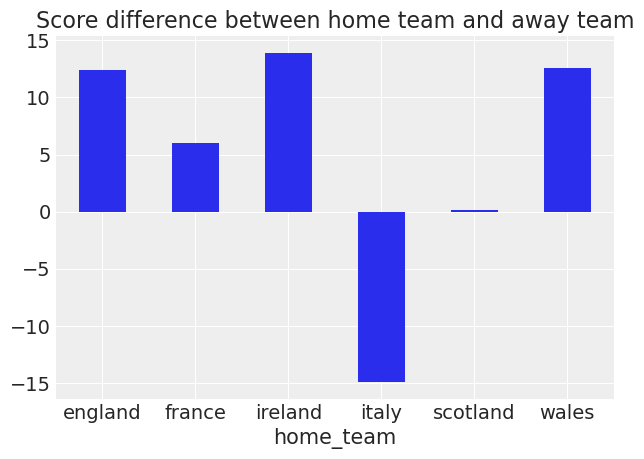

In [12]:
df_all.pivot_table("difference_non_abs", "home_team").plot(
    kind="bar",
    rot=0,
    legend=False,
    title="Score difference between home team and away team"
)

<AxesSubplot:title={'center':'Score difference between home team and away team'}, xlabel='away_team'>

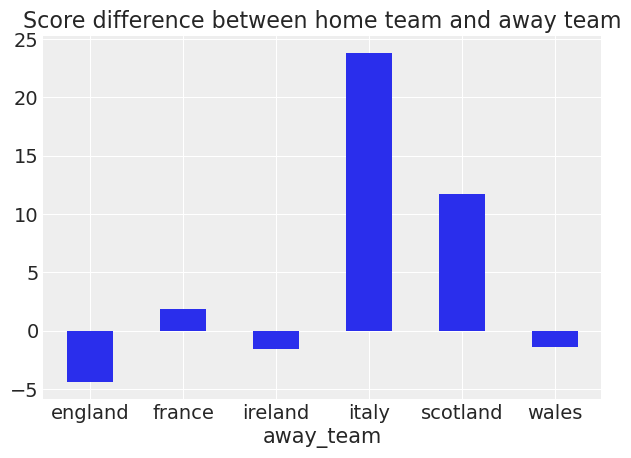

In [13]:
df_all.pivot_table("difference_non_abs", "away_team").plot(
    kind="bar",
    rot=0,
    legend=False,
    title="Score difference between home team and away team"
)

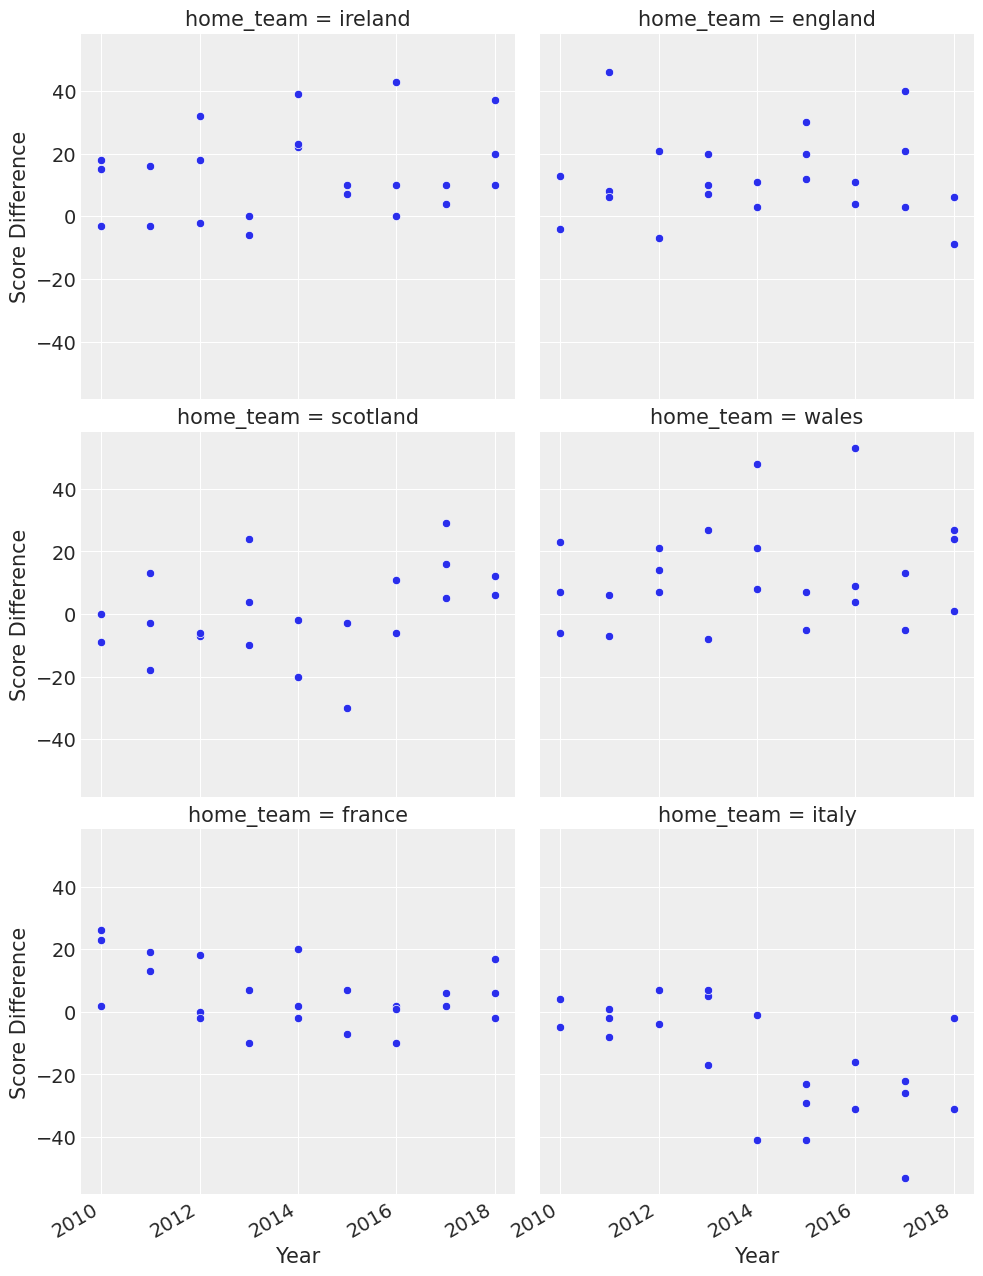

In [14]:
g = sns.FacetGrid(
    df_all,
    col="home_team",
    col_wrap=2,
    height=5
)

g.map(
    sns.scatterplot,
    "year",
    "difference_non_abs"
).set_axis_labels("Year", "Score Difference")

g.fig.autofmt_xdate()

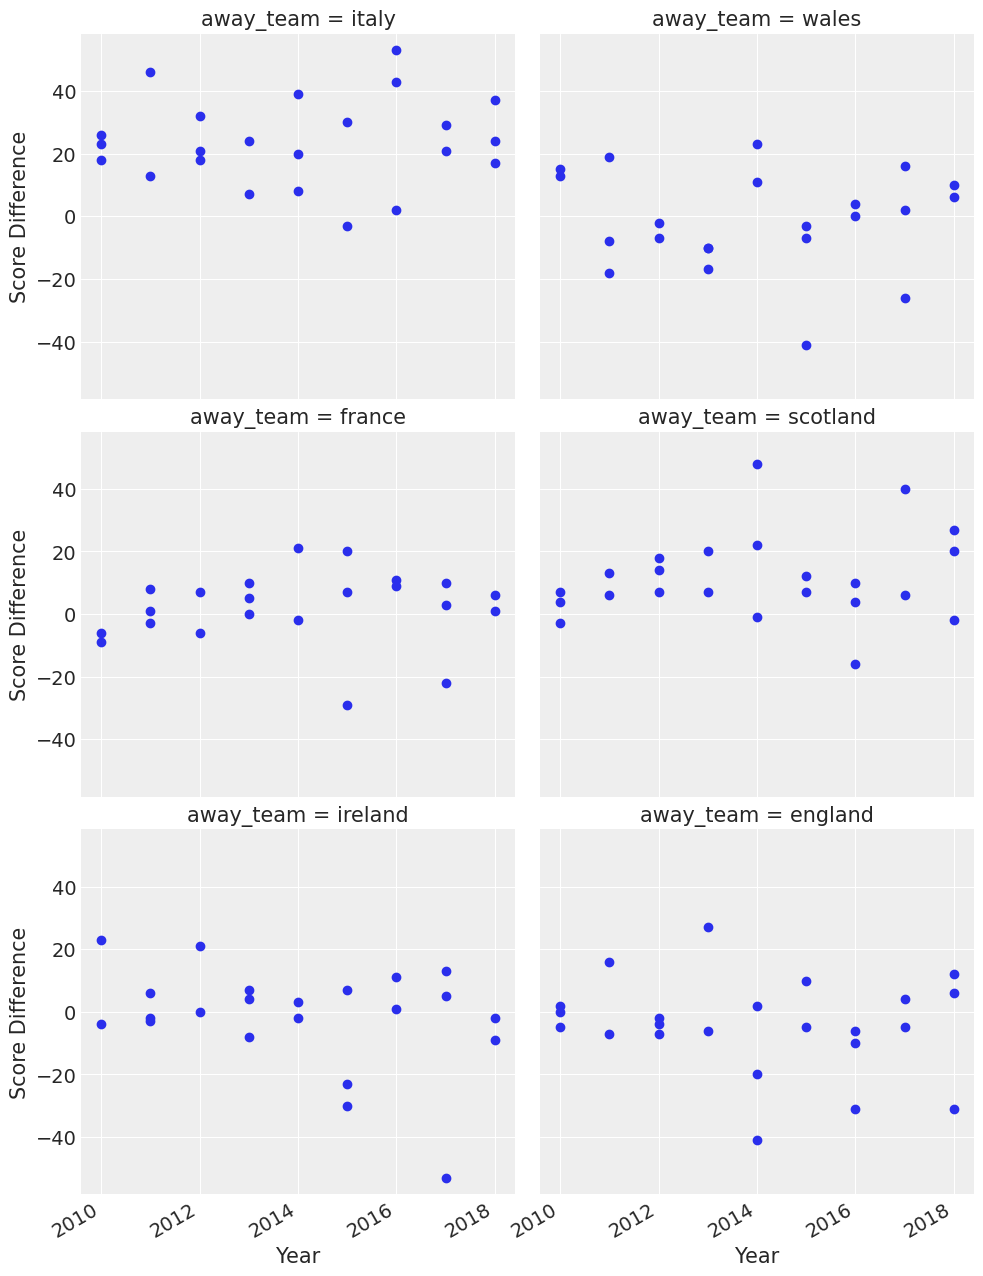

In [15]:
g = sns.FacetGrid(
    df_all,
    col="away_team",
    col_wrap=2,
    height=5,
)

g = g.map(
    plt.scatter,
    "year",
    "difference_non_abs"
).set_axis_labels("Year", "Score Difference")

g.fig.autofmt_xdate()

# The model

In [16]:
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)

num_games = df_all.shape[0]
coords = {"team": teams, "match": np.arange(num_games)}

In [17]:
with pm.Model(coords=coords) as model:
    # constant data
    home_team = pm.Data("home_team", home_idx, dims="match")
    away_team = pm.Data("away_team", away_idx, dims="match")

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_att = pm.HalfNormal("sd_att", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    atts_star = pm.Normal("atts_star", mu=0, sigma=sd_att, dims="team")
    defs_star = pm.Normal("defs_star", mu=0, sigma=sd_def, dims="team")

    atts = pm.Deterministic("atts", atts_star - tt.mean(atts_star), dims="team")
    defs = pm.Deterministic("defs", defs_star - tt.mean(defs_star), dims="team")
    home_theta = tt.exp(intercept + home + atts[home_idx] + defs[away_idx])
    away_theta = tt.exp(intercept + atts[away_idx] + defs[home_idx])

    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),
    )
    trace = pm.sample(1000, tune=1000, cores=4, return_inferencedata=True, target_accept=0.85)

NameError: name 'tt' is not defined

In [18]:
df_all

,home_team,away_team,home_score,away_score,year,difference,difference_non_abs
0,ireland,italy,29,11,2010,18,18
1,england,wales,30,17,2010,13,13
2,scotland,france,9,18,2010,9,-9
3,wales,scotland,31,24,2010,7,7
4,france,ireland,33,10,2010,23,23
...,...,...,...,...,...,...,...
130,france,england,22,16,2018,6,6
131,wales,italy,38,14,2018,24,24
132,italy,scotland,27,29,2018,2,-2
133,england,ireland,15,24,2018,9,-9
